In [3]:
import os
import shutil

os.makedirs("logs", exist_ok=True)

DATASET_DIR = "/kaggle/input/qwerty"  

for fname in ["full_ft.pt", "lora_ft.pt"]:
    shutil.copy(
        os.path.join(DATASET_DIR, fname),
        os.path.join("logs", fname)
    )

print("Logs available:", os.listdir("logs"))


Logs available: ['full_ft.pt', 'lora_ft.pt']


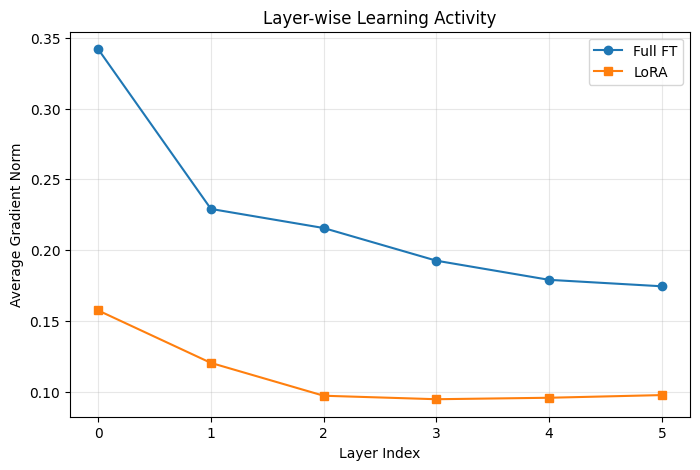

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

full_logs = torch.load("logs/full_ft.pt")
lora_logs = torch.load("logs/lora_ft.pt")

from collections import defaultdict

def collect_layer_norms(logs):
    layer_norms = defaultdict(list)

    for name, records in logs.items():

        parts = name.split(".")

        if "h" in parts:
            h_index = parts.index("h")

            if h_index + 1 < len(parts):
                layer_str = parts[h_index + 1]

                if layer_str.isdigit():
                    layer = int(layer_str)

                    for r in records:
                        layer_norms[layer].append(r["norm"])

    return layer_norms


full_layers = collect_layer_norms(full_logs)
lora_layers = collect_layer_norms(lora_logs)

max_layer = max(full_layers.keys())

full_avg = []
lora_avg = []

for i in range(max_layer + 1):

    full_avg.append(np.mean(full_layers[i]))
    lora_avg.append(np.mean(lora_layers[i]))


plt.figure(figsize=(8,5))

plt.plot(full_avg, marker="o", label="Full FT")
plt.plot(lora_avg, marker="s", label="LoRA")

plt.xlabel("Layer Index")
plt.ylabel("Average Gradient Norm")
plt.title("Layer-wise Learning Activity")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


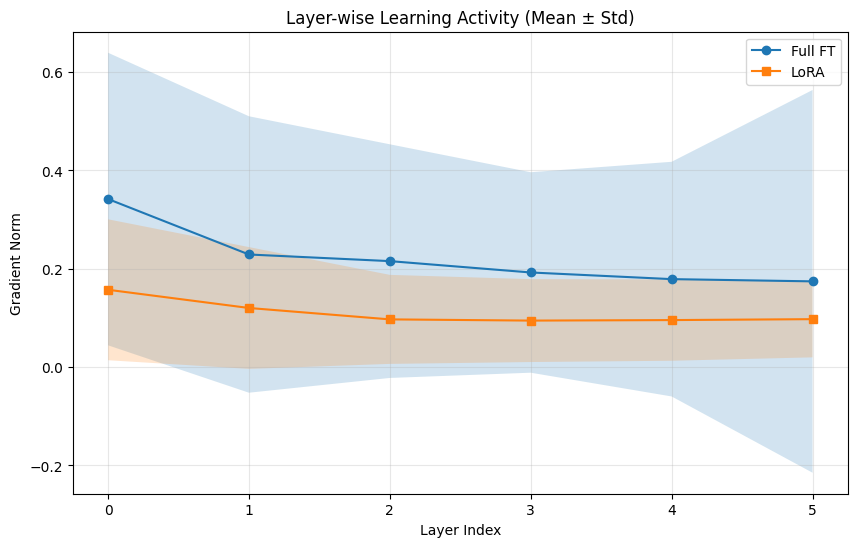

In [7]:
import numpy as np
import matplotlib.pyplot as plt

layers = sorted(full_layers.keys())

full_mean = []
full_std = []

lora_mean = []
lora_std = []

for l in layers:
    f_vals = np.array(full_layers[l])
    l_vals = np.array(lora_layers[l])
    
    full_mean.append(f_vals.mean())
    full_std.append(f_vals.std())
    
    lora_mean.append(l_vals.mean())
    lora_std.append(l_vals.std())

plt.figure(figsize=(10, 6))

plt.plot(
    layers, full_mean,
    marker='o',
    label="Full FT"
)

plt.fill_between(
    layers,
    np.array(full_mean) - np.array(full_std),
    np.array(full_mean) + np.array(full_std),
    alpha=0.2
)

plt.plot(
    layers, lora_mean,
    marker='s',
    label="LoRA"
)

plt.fill_between(
    layers,
    np.array(lora_mean) - np.array(lora_std),
    np.array(lora_mean) + np.array(lora_std),
    alpha=0.2
)

plt.xlabel("Layer Index")
plt.ylabel("Gradient Norm")
plt.title("Layer-wise Learning Activity (Mean ± Std)")

plt.legend()
plt.grid(alpha=0.3)

plt.show()
